In [1]:
import numpy as np
import pylab as plt

### Convolution theorem

This is a super important application for FFTs, because it allows us to speed up discrete convolutions:

$y_i = \sum_{k=0}^{K-1} x_{i - k} h_k$

with a _signal_ $x_i$ of size $N$, and a _kernel_ $h_k$ of size $K$.


The discrete convolution theorem says that the Fourier transform $Y$ of $\{y_i\}$ is

$Y = X \times H$

so we can compute the convolution by converting the $x$ and $h$ into Fourier space, multiplying them, and inverse-Fourier transforming to get $y$:

$y = IFFT(FFT(x) * FFT(h))$.

#0. Discussion question

Consider the computational cost of computing a convolution either through the straightforward sum, or via the FFT. What would be the cost for a data vector of length N and a kernel of length K?

Computational cost: FFT(NlogN) data at a time? sum: everythng stratightforward: N^2/N*K at the time?

#1. Where's Waldo (astronomical)

In [2]:
# Let's fetch some real astronomical imaging data:
url = 'https://www.legacysurvey.org/viewer/cutout.fits?ra=169.5885&dec=26.6341&layer=ls-dr9&pixscale=0.262&bands=r&width=256&height256'

In [4]:
%pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [requests]

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
r = requests.get(url)
# Write it out as a FITS file, read it back in using the "fitsio" package:
#import fitsio
#open('/tmp/file.fits','wb').write(r.content)
#img = fitsio.read('/tmp/file.fits')

In [4]:
# Manipulate raw byte content... it has a 2880-byte header, then 256*256 4-byte, big-endian floats.
imgdata = r.content[2880:]
imgdata = imgdata[:256*256*4]
img = np.frombuffer(imgdata, dtype='>f').reshape((256,256))

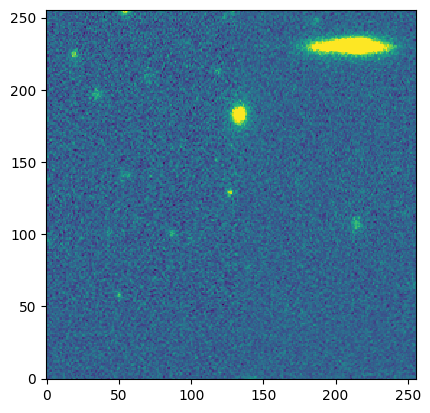

In [5]:
plt.imshow(img, interpolation='nearest', origin='lower', vmax=0.05);

We're going to pull out one row of this image, slicing through 2--3 stars.

We want to _detect_ these stars -- determine whether they are real or just noise deviations.

This image has _additive_, _pixelwise independent_, _Gaussian_ noise with _zero mean_, and therefore a _matched filter_ approach is statistically efficient.

To run a _matched filter_, we _correlate_ a _template_ of the signal we are looking for against the observed data.

_Correlation_ is closely related to _convolution_ (by flipping the template).  The template we're going to use is _symmetric_, so we'll just use convolution.

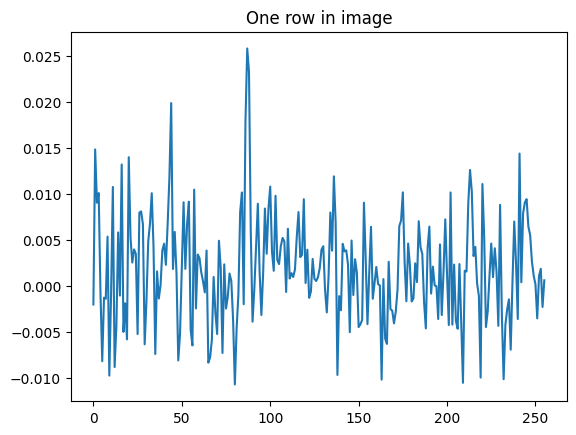

In [19]:
data = img[100,:]
plt.plot(data)
plt.title('One row in image');

The _kernel_ or _template_ we're going to use is the _point spread function_ of the image -- what a distant point of light would look like in the image.  Due to atmospheric blurring ("seeing"), this is a Gaussian-ish function.  We'll use a Gaussian.

The Gaussian we're going to make is only a few pixels wide, so we'll make a 21-pixel _kernel_ with the peak centered at pixel coordinate 10.

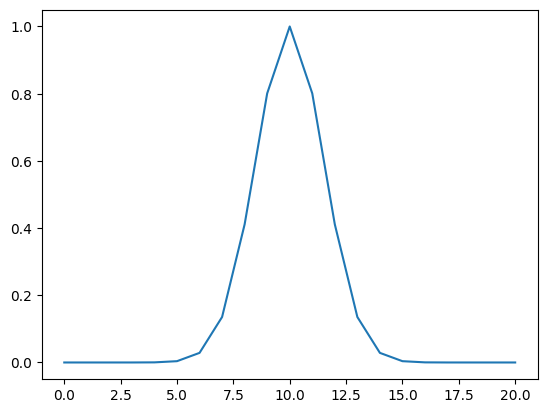

In [20]:
kernel_size = 21
kernel_center = kernel_size//2
kernel_sigma = 1.5
kernel = np.exp(-0.5 * (np.arange(kernel_size) - kernel_center)**2 / kernel_sigma**2)
plt.plot(kernel);

Let's use the `numpy.convolve` method.

Here is its manual page: https://numpy.org/doc/stable/reference/generated/numpy.convolve.html#numpy-convolve

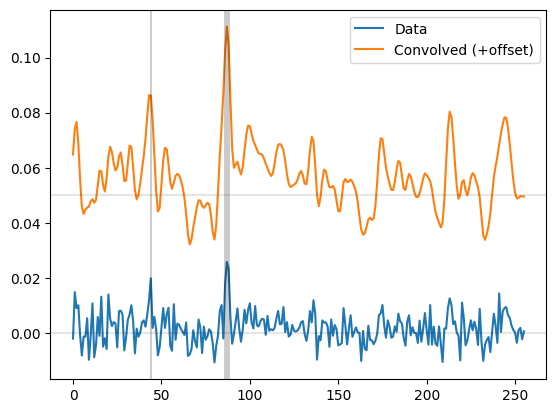

In [22]:
conv = np.convolve(data,kernel, mode='same')
##### ADD CODE: Convolve the data with the kernel
plt.plot(data, label='Data')
plt.plot(conv + 0.05, label='Convolved (+offset)')
plt.axhline(0, color='k', alpha=0.1)
plt.axhline(0.05, color='k', alpha=0.1)
# Let's mark the position of a few peaks in the data vector:
imax = np.argsort(-data)
for x in imax[:4]:
    plt.axvline(x, color='k', alpha=0.2);
plt.legend();

#Questions: Part 1

1. What do you notice about the convolved array?

2. What shape is it, compared to the `data` array?

3. How do the peaks in the `data` array align with the peaks in the `conv` array?

4. Read through the `numpy.convolve` manual page and see if you can figure out what is going on, and how to get out a `conv` array that is the same size as the original data array.

1. Convolved array is longer longer than data array.
2. Less fluctuations, but it looks like the peaks were streached horizontally. 
3. There are matching peaks between data and convolution, but they are shifted to the right.
4. Figuring out what is going on: 

numpy.convolve(a, v, mode='full') -> from documentation: 

If v is longer than a, the arrays are swapped before computation.

mode
{‘full’, ‘valid’, ‘same’}, optional
‘full’:
By default, mode is ‘full’. This returns the convolution at each point of overlap, with an output shape of (N+M-1,). At the end-points of the convolution, the signals do not overlap completely, and boundary effects may be seen.
‘same’:
Mode ‘same’ returns output of length max(M, N). Boundary effects are still visible.
‘valid’:
Mode ‘valid’ returns output of length max(M, N) - min(M, N) + 1. The convolution product is only given for points where the signals overlap completely. Values outside the signal boundary have no effect.

-> we need to change the mode to same


In addition to `numpy.convolve`, there is also a function `scipy.ndimage.convolve1d`, with manual here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html#scipy.ndimage.convolve1d

Have a look at the `mode` and `origin` arguments.  What do you think is the best / desired behavior for our current task of detecting stars?

Desired behaviour: matching the peaks

Intuitively, the _matched filter_ "gathers up" the signal from the star.  The convolution operation "slides" our template over the image, and it produces the largest result where the data matches the kernel.  When there is only noise, that tends to average down toward zero.

We can estimate the per-pixel noise in this image by looking at the difference between nearby pixels, and taking the median (so that we are robust to pixels in stars):

In [23]:
# Grab pairs of pixels separated by 3 pixels (in steps of 6 pixels)
slice1 = (slice(0,-3,6),slice(0,-3,6))
slice2 = (slice(3,None,6),slice(3,None,6))
# median absolute difference
mad = np.median(np.abs(img[slice1] - img[slice2]).ravel())
# this correction factor takes MAD to sigma for a Gaussian
noise = 1.048 * mad
print('Noise estimate =', noise)

Noise estimate = 0.005601071


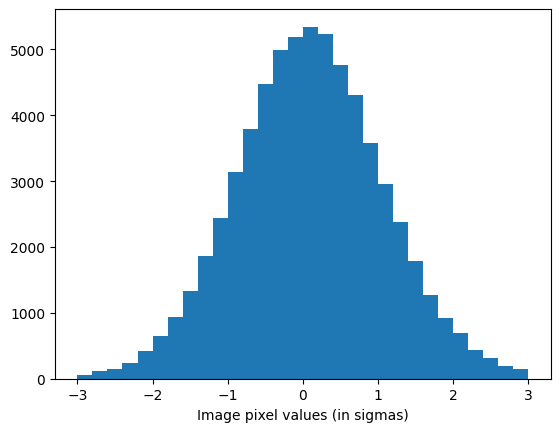

In [24]:
# Let's just histogram the image pixels to confirm that noise estimate


plt.hist(img.ravel() / noise, range=(-3, +3), bins=30)
plt.xlabel('Image pixel values (in sigmas)');

# Does this look right (ie, like a Gaussian with unit variance)?
##### ADD CODE: Plot a Gaussian with unit variance on the same plot and check.

# Questions: Part 2

1. Can you compute what the convolution operation would return for randomly drawn Gaussian noise with sigma = `noise`?

2. What about a "star" that looks exactly like the template, what will the convolution operation return for that?

3. How big must the convolved answer be if we want it to be 5 times larger than the standard deviation you would expect from pure noise?  That's what we would call a "5 sigma detection".


4. How often would you expect to find a 5-sigma deviation purely from Gaussian noise?

5. Try randomly sampling a very long vector (like 10 million entries), run the convolution operation, and count how many values are above 5 sigma.

# DIY convolution scheme



Now we're going to try performing the convolution using the Fourier Transform (ourselves)...

We first have to pad our `kernel` to be the same length as the `data`

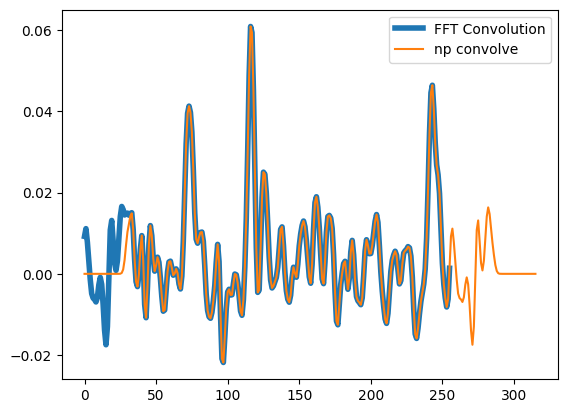

In [18]:
pad_kernel = np.zeros(len(data))
pad_kernel[:len(kernel)] = kernel

# Now use Numpy's fft algorithms (np.fft.rfft and np.fft.irfft) to convolve the data and the above padded kernel
##### ADD CODE BELOW (follow the definition given at the top of the notebook)

conv_fft = # store the DIY convolution result here
plt.plot(conv_fft, label='FFT Convolution', lw=4); # Plot it
plt.plot(conv, label='np convolve'); # This plots the result from np.convolve
plt.legend();

There are a couple of differences visible here:

* The FFT is _periodic_, so at the endpoints, the convolution _wraps around_!
* If your kernel is not centered at 0, there will be a _shift_.
* (For a kernel like ours, you might have to put the negative side of the kernel _reversed_ at the _end_ of the `pad_kernel` array!)
* The FFT will naturally produce a result the same size as the inputs
* We would probably _pad_ the data out to the next power of two.  This gives us an opportunity to control what happens at the endpoints.


